In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [18]:
# Load the dataset
data = pd.read_csv("data_after_EDA.csv")
nlp_data = pd.read_csv('updated_dataset.csv', usecols=['Main Diagnosis'] + ['word_' + str(i) for i in range(100)])

# Drop the 'Main Diagnosis' column
data.drop(columns=['Hospital','Deparment','Main Diagnosis','Discharge Time'], inplace=True)

# Convert Arrival Time and Discharge Time to datetime
data['Arrival Time'] = pd.to_datetime(data['Arrival Time'])
data['Hour'] = data['Arrival Time'].dt.hour
data['DayOfYear'] = data['Arrival Time'].dt.dayofyear

# Convert the 'Severity Level' column to numerical
level_mapping = {
    'Level Ⅰ': 1,
    'Level Ⅱ': 2,
    'Level Ⅲ': 3,
    'Level Ⅳ': 4,
    'Level Ⅴ': 5,
    'Unrated': 0
}

data['Severity Level'] = data['Severity Level'].replace(level_mapping)
data['Severity Level'] = data['Severity Level'].astype(int)

  ROWNUM Eligibility Class  Gender        Arrival Time  Severity Level  \
0      1  ROYAL COMMISSION  Female 2023-12-13 13:17:48               4   
1      2  ROYAL COMMISSION  Female 2023-12-08 10:59:28               3   
2      3  ROYAL COMMISSION  Female 2023-11-05 14:03:02               3   
3      4  ROYAL COMMISSION  Female 2023-10-07 22:57:41               3   
4      5  ROYAL COMMISSION  Female 2023-10-21 21:32:17               4   

   Waiting Time (Minutes)  Length of Stay (Minutes)  Treatment Time(Minutes)  \
0                    14.0                     205.0                    191.0   
1                     7.0                     111.0                    104.0   
2                    24.0                      51.0                     27.0   
3                    26.0                      71.0                      0.0   
4                    56.0                      98.0                     42.0   

   Cluster  No Treatment  Hour  DayOfYear  Emergency  
0        2         

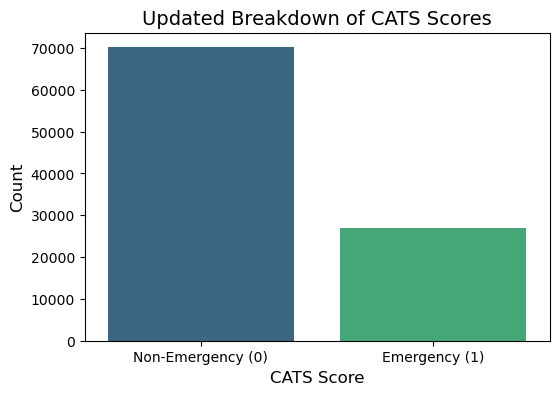

In [19]:
# Grouping the KTAS classes into emergency (1) and non-emergency (0)
data["Emergency"] = np.where(data["Severity Level"] < 4, 1, 0)
print(data.head())

# Count the values in Emergency
CTAS_counts = data['Emergency'].value_counts()

# Create a bar plot
plt.figure(figsize=(6, 4))
sns.barplot(x=CTAS_counts.index, y=CTAS_counts.values, palette='viridis')

# Set the labels and title
plt.xlabel('CTAS Score', size=12)
plt.ylabel('Count', size=12)
plt.title('Updated Breakdown of CTAS Scores', size=14)

# Show the plot
plt.xticks(ticks=[0, 1], labels=['Non-Emergency (0)', 'Emergency (1)'])  # Customize x-ticks if necessary
plt.show()

In [20]:
# Combine the data with the NLP data
combined_data = data.join(nlp_data, how='left')
print(combined_data.head())

  ROWNUM Eligibility Class  Gender        Arrival Time  Severity Level  \
0      1  ROYAL COMMISSION  Female 2023-12-13 13:17:48               4   
1      2  ROYAL COMMISSION  Female 2023-12-08 10:59:28               3   
2      3  ROYAL COMMISSION  Female 2023-11-05 14:03:02               3   
3      4  ROYAL COMMISSION  Female 2023-10-07 22:57:41               3   
4      5  ROYAL COMMISSION  Female 2023-10-21 21:32:17               4   

   Waiting Time (Minutes)  Length of Stay (Minutes)  Treatment Time(Minutes)  \
0                    14.0                     205.0                    191.0   
1                     7.0                     111.0                    104.0   
2                    24.0                      51.0                     27.0   
3                    26.0                      71.0                      0.0   
4                    56.0                      98.0                     42.0   

   Cluster  No Treatment  ...  word_90  word_91  word_92 word_93  word_94 

In [21]:
from sklearn.preprocessing import LabelEncoder
data['Waiting Time (Minutes)'] = data['Waiting Time (Minutes)'].astype(int)
data['Length of Stay (Minutes)'] = data['Length of Stay (Minutes)'].astype(int)
data['Treatment Time(Minutes)'] = data['Treatment Time(Minutes)'].astype(int)

label_encoders = {}
for column in ['Eligibility Class', 'Gender']:
    le = LabelEncoder()
    combined_data[column] = le.fit_transform(combined_data[column])
    label_encoders[column] = le

# Select features
features = combined_data[['Eligibility Class', 'Gender', 'Waiting Time (Minutes)', 'Length of Stay (Minutes)', 'Treatment Time(Minutes)', 'Cluster', 'No Treatment'] + [f'word_{i}' for i in range(100)]]
target = combined_data['Severity Level']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
print(X_train.dtypes)


Eligibility Class             int32
Gender                        int32
Waiting Time (Minutes)      float64
Length of Stay (Minutes)    float64
Treatment Time(Minutes)     float64
                             ...   
word_95                       int64
word_96                       int64
word_97                       int64
word_98                       int64
word_99                       int64
Length: 107, dtype: object


In [22]:
# Initialize classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=200),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

# Train
results = {}
for name, clf in classifiers.items():
    # Fit the model
    clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    results[name] = {'accuracy': accuracy, 'report': report, 'confusion_matrix': confusion}

d:\Anaconda3\envs\prmls_new\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\Anaconda3\envs\prmls_new\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
d:\Anaconda3\envs\prmls_new\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
d:\Anaconda3\envs\prmls_new\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
d:\Anaconda3\envs\prmls_new\lib\site-packages\sklearn\ensemb

In [ ]:
# Evaluate each classifier
for name, result in results.items():
    print(f"Model: {name}")
    print("Accuracy:", result['accuracy'])
    print("Classification Report:")
    print(result['report'])
    sns.heatmap(result['confusion_matrix'], annot=True, fmt="d")
    plt.title(f'Confusion Matrix for {name}')
    plt.show()